This practical work, on motion estimation, has 2 different parts, corresponding to two families of algorithms that we have seen in class:
- Block matching algorithms
- Optic flow

You are asked to complete the different algorithms and to try it. Also, please answer to the theoretical questions, in the notebook.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter
from scipy.signal import convolve2d

# I - Block matching algorithms
## I-1 - Unregularized algorithms
### I-1-a - Unregularized SSD-based algorithm

First, read the two images 'flower_cif_1.mat' and 'flower_cif_1.mat', which are two consecutive frames of a video sequence. You will have to estimate the motion between these frame, using block matching algorithms.

In [2]:
im1 = loadmat("flower_cif_1.mat")["im1"]
im1 = im1.astype("float")
im2 = loadmat("flower_cif_2.mat")["im2"]
im2 = im2.astype("float")

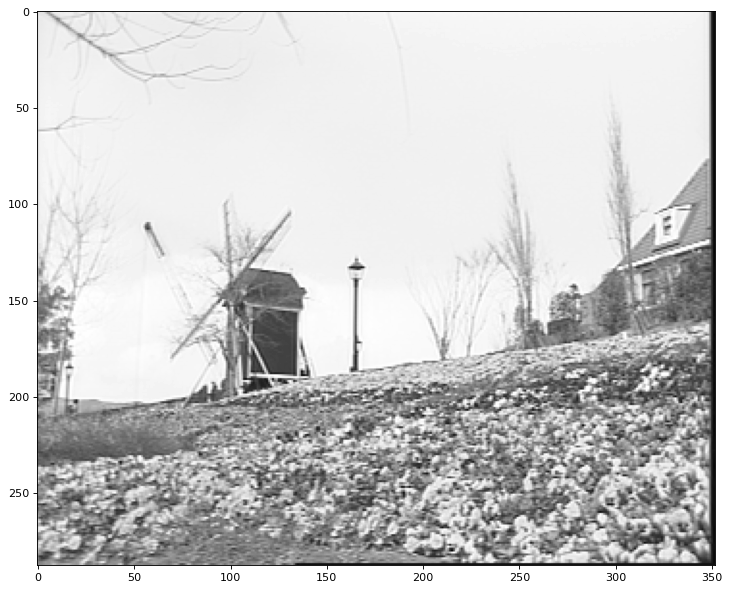

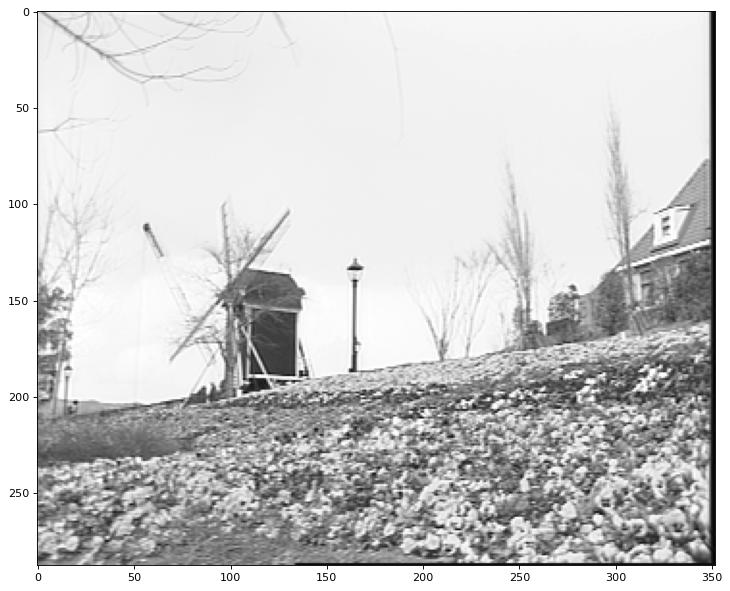

In [3]:
plt.figure(figsize=(16, 9), dpi=80), plt.imshow(im1, cmap="gray")
plt.figure(figsize=(16, 9), dpi=80), plt.imshow(im2, cmap="gray")
plt.show()

First, you will have to encode a block matching using the SSD criterion. Some default values of the algorithm are given below: the number of column and rows in each block, and the search radius.

In [4]:
brow = 8  # Number of rows per block
bcol = 8  # Number of columns per block
search_radius = 8  # Search radius

Fill the me_ssd function in the cell below. First, implement the unregularized part of the function (you will implement the regularized one later). Do not pay attention to the computePredictor and initVector (we will speak about them later on).

In [5]:
def initVector(ref, cur):
    """
    Performs an initialization for the first regularizers

    Parameters
    ----------
    ref : np.array
        Reference image.
    cur : np.array
        Reference image.

    Returns
    -------
    pV : np.array (vector of size 2)
        Regularizer for displacement.

    """
    step = 8
    cont = 4 * step

    REF = gaussian_filter(ref, 1.0)  # Unclear how to set sigma
    CUR = gaussian_filter(cur, 1.0)

    CUR = CUR[
        cont + 1 : (np.shape(CUR)[0] - cont) : step,
        cont + 1 : (np.shape(CUR)[1] - cont) : step,
    ]
    SSDMIN = np.inf

    pV = np.zeros(2)

    for globR in range(-cont, cont):
        for globC in range(-cont, cont):
            RR = REF[
                cont + 1 - globR : (cont - globR + np.shape(CUR)[0] * step) : step,
                cont + 1 - globC : (cont - globC + np.shape(CUR)[1] * step) : step,
            ]
            SSD = np.sum((RR - CUR) ** 2)

            if SSD < SSDMIN:
                SSDMIN = SSD
                pV[0] = globR
                pV[1] = globC

    return pV


def computePredictor(r, c, brow, bcol, mvf, ref, cur):
    """
    compute predictor gives the median of the mvf of the blocks :
        - to the left of the current block
        - above the current block
        - upper left of the current block

    If such blocks do not exist due to the border effects, they are not taken into account.

    Parameters
    ----------
    See usage in the me_ssd function

    Returns
    -------
    pV : Median of the mvf of the neighboor blocks
    """
    if r < brow and c < bcol:
        pV = initVector(ref, cur)

    elif r < brow:  # First row
        pV = mvf[r, c - bcol, :]

    elif c < bcol:  # First column
        pV = mvf[r - brow, c, :]

    else:  # Inside
        if c >= np.shape(mvf)[1] - bcol:  # Last column
            vC = mvf[r - brow, c - bcol, :]

        else:  # Not the last column
            vC = mvf[r - brow, c + bcol, :]

        vA = mvf[r, c - bcol, :]
        vB = mvf[r - brow, c, :]

        temp = np.array([vA, vB, vC]).T

        pV = np.median(temp, axis=1)

    pV = pV.ravel()

    return pV


def me_ssd(cur, ref, brow, bcol, search, lamb=0):
    """
    ME BMA full search Motion estimation
    mvf, prediction = me_ssd(cur, ref, brow, bcol, search);

    A regularization constraint can be used
    mvf = me(cur, ref, brow, bcol, search, lambda);
    In this case the function minimize SAD(v) + lambda * error(v)
    where error(v) is the difference between the candidate vector v and the
    median of its avalaible neighbors.

    Code inspired from the one of Marco Cagnazzo


    Parameters
    ----------
    cur : numpy array
        Current (i.e. second) frame of the video.
    ref : numpy array
        Previous (i.e. first) frame of the video.
    brow : int
        Number of rows in each block.
    bcol : int
        Number of rows in each block.
    search : int
        Search radius
    lamb : double
        Regularization parameter

    Returns
    -------
    mvf : numpy array
        Estimated Motion Vector Field (MVF). Horizontal components are on
        index 0 and vertical components are on index 1.
    prediction : numpy array
         Predicted frame based on the motion estimation.
    """

    extension = search

    ref_extended = cv2.copyMakeBorder(
        ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE
    )  # To avoid border effect

    prediction = np.zeros(np.shape(cur))
    lamb *= brow * bcol

    mvf = np.zeros((np.shape(cur)[0], np.shape(cur)[1], 2))

    # Non-regularized search
    if lamb == 0.0:
        # for each block in the current image, find the best corresponding block in the reference image
        for r in range(0, cur.shape[0], brow):
            for c in range(0, cur.shape[1], bcol):
                # current block selection
                B = cur[r : r + brow, c : c + brow]  # Block

                # Initialization:
                best_drow, best_dcol = 0, 0
                costMin = np.inf
                Rbest = np.zeros(B.shape)

                # Loop on candidate displacement vectors
                # dcol = candidate displacement vector over the columns
                for dcol in range(c - search, c + search):
                    # drow = candidate displacement vector over the rows
                    for drow in range(r - search, r + search):
                        B_candidate = ref_extended[
                            drow + search : drow + brow + search,
                            dcol + search : dcol + bcol + search,
                        ]
                        cost = np.linalg.norm(B - B_candidate) ** 2

                        # Save the results if they are better than the previous ones
                        if cost < costMin:
                            costMin = cost
                            Rbest = B_candidate
                            best_drow = drow
                            best_dcol = dcol

                # Once the loop is over, save the best row displacement field
                mvf[r : r + brow, c : c + bcol, 0] = r - best_drow
                # Once the loop is over, save the best column displacement field
                mvf[r : r + brow, c : c + bcol, 1] = c - best_dcol
                prediction[r : r + brow, c : c + bcol] = Rbest

    else:  # Regularized search
        # for each block in the current image, find the best corresponding block in the reference image
        for r in range(0, cur.shape[0], brow):
            for c in range(0, cur.shape[1], bcol):
                # current block selection
                B = cur[r : r + brow, c : c + bcol]  # Block

                # Initializations
                costMin = np.inf
                Rbest = np.zeros(B.shape)
                best_drow, best_dcol = 0, 0

                # Neighbours : pV is the regularization vector. The regularizer must be such that the estimated displacement is not too far away from pV
                pV = computePredictor(r, c, brow, bcol, mvf, ref, cur)

                # Loop on candidate vectors
                # dcol = candidate displacement vector over the columns
                for dcol in range(c - search, c + search):
                    # rcol = candidate displacement vector over the rows
                    for drow in range(r - search, r + search):
                        B_candidate = ref_extended[
                            drow + search : drow + brow + search,
                            dcol + search : dcol + bcol + search,
                        ]
                        # here, the REGULARIZED cost function
                        cost = (
                            np.linalg.norm(B - B_candidate) ** 2
                            + lamb * np.linalg.norm(np.array([drow, dcol]) - pV) ** 2
                        )

                        # Save the results if they are better than the previous ones
                        if cost < costMin:
                            costMin = cost
                            Rbest = B_candidate
                            best_drow = drow
                            best_dcol = dcol

                # Once the loop is over, save the best row displacement field
                mvf[r : r + brow, c : c + bcol, 0] = r - best_drow
                # Once the loop is over, save the best column displacement field
                mvf[r : r + brow, c : c + bcol, 1] = c - best_dcol
                prediction[r : r + brow, c : c + bcol] = Rbest

    mvf = -mvf  # For compatibility with standards

    return mvf, prediction

In [6]:
mvf_ssd, prediction = me_ssd(im2, im1, brow, bcol, search_radius)

Using the function `displayMVF`, show the motion vector field. Write your remarks. Are there errors? If yes, where and why?

Change the block size and the search area radius. How does it impact your results?

In [7]:
def displayMVF(I, mvf, subsamp):
    row, col = np.shape(I)

    # Subsample dense MVF
    vectRow = mvf[0:row:subsamp, 0:col:subsamp, 0]
    vectCol = mvf[0:row:subsamp, 0:col:subsamp, 1]

    # Determine vector origins
    X, Y = np.meshgrid(np.arange(0, col, subsamp), np.arange(0, row, subsamp))
    X = X + np.floor(subsamp / 2.0)
    Y = Y + np.floor(subsamp / 2.0)

    # Show image
    plt.figure(figsize=(16, 9), dpi=80)
    plt.imshow(I, cmap="gray")

    plt.quiver(X, Y, vectCol, -vectRow)

    plt.show()

    return

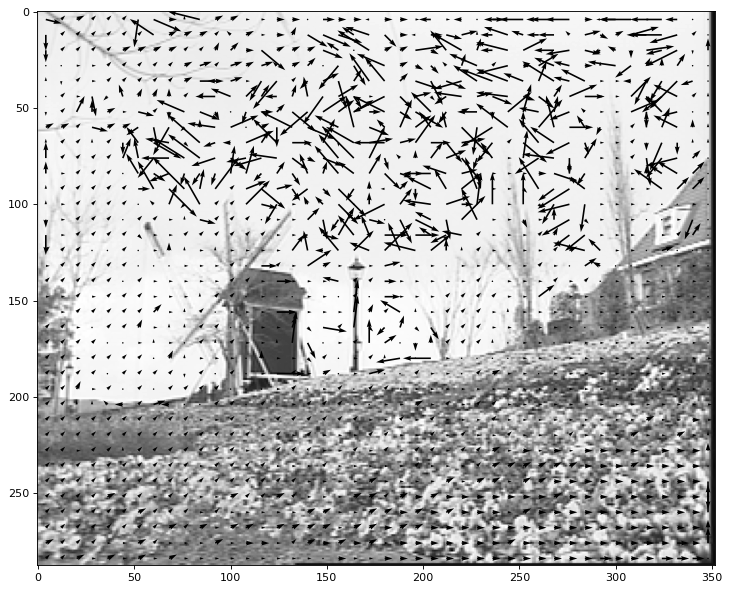

In [8]:
displayMVF(im1, mvf_ssd, brow)

**Answer**:

*Remarks*:
   1. Block Size (`brow`, `bcol`) and Search Radius (`search`):
      - The block size and search radius parameters play a pivotal role in the motion estimation algorithm's performance.
      - Smaller block sizes provide finer granularity in capturing motion details, albeit at the cost of increased computational overhead.
      - Conversely, larger block sizes offer computational efficiency but might miss out on capturing subtle motion nuances.
      - Adjusting the search radius influences the algorithm's ability to explore potential motion vectors. A larger search radius enhances the chances of finding the best match but requires more computational resources.
      - Empirical evaluation is essential to strike a balance between the desired level of accuracy and computational efficiency, tailored to the specific needs of the application.
   2. Regularization Parameter (`lamb`): The regularization parameter (`lamb`) regulates the balance between preserving fidelity to the data and enforcing regularization constraints during motion estimation.
   3. Regularized Cost Function: The regularization term introduces a penalty for deviations from the predictor vector (`pV`). This helps in mitigating artifacts and enhancing the quality of motion estimation.

*Errors*:
   - One notable error arises when dealing with homogenous regions such as the sky. In such cases, where blocks lack distinctive features, the block matching algorithm struggles to determine the best match in the second frame. As a result, it may arbitrarily assign a block within the search window, leading to inaccurate displacement vectors.
   - To mitigate this issue, techniques such as employing more sophisticated motion estimation algorithms or incorporating additional pre-processing steps to enhance feature discrimination in homogeneous regions could be considered. One could also adjust the parameter `lamb` to account for the regularization term.

Motion compensation: now that we have computed the movement vector field, we can compute the motion compensated image using the `fracMc` function. Display the motion compensated image. What can you observe ?

In [9]:
def fracMc(ref, mvf, outofbound=20):
    [rows, cols] = np.shape(ref)

    # Initial coordinates, used to infer the new coordinates
    mc_c, mc_r = np.meshgrid(np.arange(cols), np.arange(rows))

    mc_r_tmp = mc_r + mvf[:, :, 0]  # Row coordinates, after the movement
    mc_c_tmp = mc_c + mvf[:, :, 1]  # Column coordinates, after the movement

    extension = outofbound
    # Padded image
    ref = cv2.copyMakeBorder(
        ref, extension, extension, extension, extension, cv2.BORDER_REFLECT
    )

    # Row coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    mc_r = mc_r_tmp + extension
    # Column coordinates, after the movement, in which we want to do the interpolation (in the padded image)
    mc_c = mc_c_tmp + extension

    # Original coordinates, at which we know the data points
    colMeshGrid, rowMeshGrid = np.meshgrid(
        np.arange(cols + 2 * extension), np.arange(rows + 2 * extension)
    )

    # Put the input coordinates into the form of an array, to mach scipy format
    points = np.zeros((np.shape(ref)[0] * np.shape(ref)[1], 2))
    points[:, 0] = colMeshGrid.reshape(np.shape(ref)[0] * np.shape(ref)[1])
    points[:, 1] = rowMeshGrid.reshape(np.shape(ref)[0] * np.shape(ref)[1])

    values = ref.reshape(np.shape(ref)[0] * np.shape(ref)[1])

    # Put the coordinates in which we want ot do the interpolation into the form of an array, to mach scipy format
    points_inter = np.zeros((rows * cols, 2))
    points_inter[:, 0] = mc_c.reshape(rows * cols)
    points_inter[:, 1] = mc_r.reshape(rows * cols)

    motcomp = griddata(points, values, points_inter, "linear")

    motcomp = motcomp.reshape(rows, cols)

    return motcomp

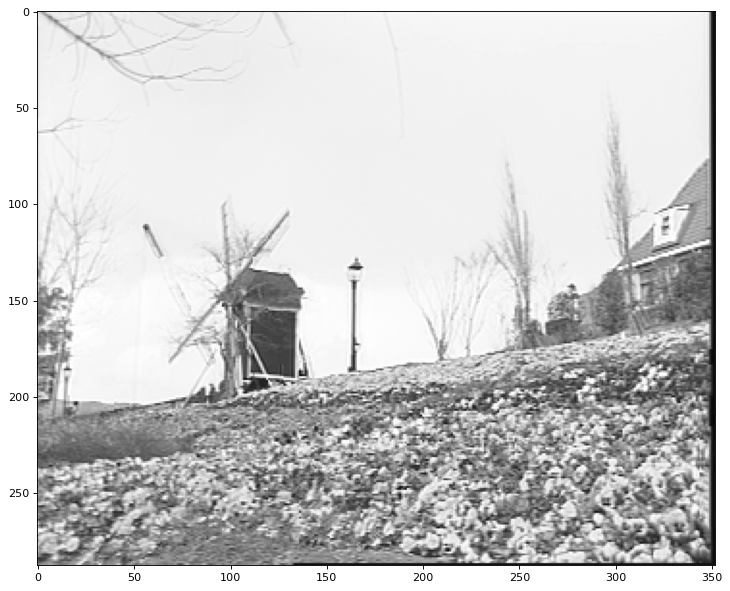

In [10]:
mc_ssd = fracMc(im1, mvf_ssd)

plt.figure(figsize=(16, 9), dpi=80)
plt.imshow(mc_ssd, cmap="gray")
plt.show()

**Answer**:

Upon motion compensation using the `fracMc` function, the resulting motion-compensated image appears to align well with both the reference frame and the current frame. Visually, this coherence suggests that the motion estimation process effectively captured the motion between consecutive frames.

However, for a more rigorous quantitative analysis of the similarity between frames, it is advisable to utilize metrics such as Peak Signal-to-Noise Ratio (PSNR). PSNR provides a numerical measure of the quality of the motion-compensated image relative to the original frames, allowing for a more precise assessment of the accuracy of the motion estimation process.

Compute the PSNR between the motion compensated and the current images.

Recall the definition of PSNR. Code the PSNR function. Compute it using the BM algorithm results, with different parameter values. Explain what you observe.

Is the PSNR between the motion-compensated image and `im2` better than between `im1` and `im2`? Explain why.

In [11]:
def PSNR(im1, im2):
    """
    Computes the PSNR between im1 and im2. The two images must have the same size.

    Parameters
    ----------
    im1, im2 : np array
        Two images.

    Returns
    -------
    psnr : float
        Peak Signal-to-Noise Ratio (PSNR) value.
    """
    # Ensure images have the same size
    assert im1.shape == im2.shape, "Images must have the same size"

    # Maximum possible pixel value
    MAX_I = 255.0  # Assuming 8-bit images

    # Calculate Mean Squared Error (MSE)
    mse = np.mean((im1 - im2) ** 2)

    # Calculate PSNR
    psnr = 20 * np.log10(MAX_I) - 10 * np.log10(mse)

    return psnr

In [12]:
psnr_ssd = PSNR(im2, mc_ssd)
print(psnr_ssd)

23.226778206199043


In [13]:
print(PSNR(im2, im1))

18.786509322935075


**Answer**:

To compute the Peak Signal-to-Noise Ratio (PSNR) between two images, we utilize the following formula:

\begin{align*}
\text{PSNR} &= 10 \cdot \log_{10}\bigg(\frac{\text{MAX}_\text{I}^2}{\text{MSE}}\bigg)\\
&= 20 \cdot \log_{10}(\text{MAX}_\text{I}) - 10 \cdot \log_{10}(\text{MSE})
\end{align*}

where:
- $\text{MAX}_\text{I}$ is the maximum possible pixel value of the images (e.g., 255 for 8-bit images).
- $\text{RMSE}$ (Root Mean Squared Error) is the square root of the Mean Squared Error (MSE), which is the average squared difference between corresponding pixels of the two images.

We can compute the PSNR between the motion-compensated frame and the current frame (`im2`) using different parameter values for the block matching algorithm. Observations and conclusions can then be drawn based on the PSNR values obtained.

If the PSNR between the motion-compensated image and `im2` is higher than the PSNR between `im1` and `im2`, it indicates that the motion compensation process has effectively reduced the error between the predicted image and the actual image (`im2`). This improvement is attributed to the fact that motion compensation aligns similar regions between frames, thereby reducing redundancy and improving compression efficiency.

However, if the PSNR does not improve or worsens, it suggests that the motion compensation did not accurately predict the motion between frames, or the block matching parameters were not optimal for the given content. Errors derived from homogeneous regions, such as the sky, may significantly contribute to a considerable difference between the motion-compensated image and the current frame.

### I-1-b Unregularized SAD-based algorithm

Now, we will use the SAD as a metric for the block matching algorithm. To do that, implement the unregularized part of the `me_sad` algorithm. Please note that you function should be very similar to `me_ssd`, except for the metric (as such, as a starting point, you can copy paste what you have proposed for `me_ssd`).

In [14]:
def computePredictor(r, c, brow, bcol, mvf, ref, cur):
    """
    compute predictor gives the median of the mvf of the blocks :
        - to the left of the current block
        - above the current block
        - upper left of the current block

    If such blocks do not exist due to the border effects, they are not taken into account.

    Parameters
    ----------
    See usage in the me_ssd function

    Returns
    -------
    pV : Median of the mvf of the neighboor blocks

    """
    if r < brow and c < bcol:
        pV = initVector(ref, cur)

    elif r < brow:  # First row
        pV = mvf[r, c - bcol, :]

    elif c < bcol:  # First column
        pV = mvf[r - brow, c, :]

    else:  # Inside
        if c >= np.shape(mvf)[1] - bcol:  # Last column
            vC = mvf[r - brow, c - bcol, :]

        else:  # Not the last column
            vC = mvf[r - brow, c + bcol, :]

        vA = mvf[r, c - bcol, :]
        vB = mvf[r - brow, c, :]

        temp = np.array([vA, vB, vC]).T

        pV = np.median(temp, axis=1)

    pV = pV.ravel()

    return pV


def initVector(ref, cur):
    """
    Performs an initialization for the first regularizers

    Parameters
    ----------
    ref : np.array
        Reference image.
    cur : np.array
        Reference image.

    Returns
    -------
    pV : np.array (vector of size 2)
        Regularizer for displacement.

    """

    step = 8
    cont = 4 * step

    REF = gaussian_filter(ref, 1.0)  # Unclear how to set sigma
    CUR = gaussian_filter(cur, 1.0)

    CUR = CUR[
        cont + 1 : (np.shape(CUR)[0] - cont) : step,
        cont + 1 : (np.shape(CUR)[1] - cont) : step,
    ]
    SSDMIN = np.inf

    pV = np.zeros(2)

    for globR in range(-cont, cont):
        for globC in range(-cont, cont):
            RR = REF[
                cont + 1 - globR : (cont - globR + np.shape(CUR)[0] * step) : step,
                cont + 1 - globC : (cont - globC + np.shape(CUR)[1] * step) : step,
            ]
            SSD = np.sum((RR - CUR) ** 2)

            if SSD < SSDMIN:
                SSDMIN = SSD
                pV[0] = globR
                pV[1] = globC

    return pV


def me_sad(cur, ref, brow, bcol, search, lamb=0):
    """
    ME BMA full search Motion estimation
    mvf, prediction = me_ssd(cur, ref, brow, bcol, search);

    A regularization constraint can be used
    mvf = me(cur, ref, brow, bcol, search, lambda);
    In this case the function minimize SAD(v) + lambda * error(v)
    where error(v) is the difference between the candidate vector v and the
    median of its avalaible neighbors.

    Code inspired from the one of Marco Cagnazzo


    Parameters
    ----------
    cur : numpy array
        Current (i.e. second) frame of the video.
    ref : numpy array
        Previous (i.e. first) frame of the video.
    brow : int
        Number of rows in each block.
    bcol : int
        Number of rows in each block.
    search : int
        Search radius
    lamb : double
        Regularization parameter

    Returns
    -------
    mvf : numpy array
        Estimated Motion Vector Field (MVF). Horizontal components are on
        index 0 and vertical components are on index 1.
    prediction : numpy array
         Predicted frame based on the motion estimation.
    """

    extension = search

    ref_extended = cv2.copyMakeBorder(
        ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE
    )

    prediction = np.zeros(np.shape(cur))
    lamb *= brow * bcol

    mvf = np.zeros((np.shape(cur)[0], np.shape(cur)[1], 2))

    # Non-regularized search
    if lamb == 0.0:
        # for each block in the current image, find the best corresponding block in the reference image
        for r in range(0, cur.shape[0], brow):
            for c in range(0, cur.shape[1], bcol):
                # current block selection
                B = cur[r : r + brow, c : c + brow]  # Block

                # Initialization:
                best_drow, best_dcol = 0, 0
                costMin = np.inf
                Rbest = np.zeros(B.shape)

                # Loop on candidate displacement vectors
                # dcol = candidate displacement vector over the columns
                for dcol in range(c - search, c + search):
                    # drow = candidate displacement vector over the rows
                    for drow in range(r - search, r + search):
                        B_candidate = ref_extended[
                            drow + search : drow + brow + search,
                            dcol + search : dcol + bcol + search,
                        ]
                        cost = np.sum(np.abs(B - B_candidate))

                        # Save the results if they are better than the previous ones
                        if cost < costMin:
                            costMin = cost
                            Rbest = B_candidate
                            best_drow = drow
                            best_dcol = dcol

                # Once the loop is over, save the best row displacement field
                mvf[r : r + brow, c : c + bcol, 0] = r - best_drow
                # Once the loop is over, save the best column displacement field
                mvf[r : r + brow, c : c + bcol, 1] = c - best_dcol
                prediction[r : r + brow, c : c + bcol] = Rbest

    else:  # Regularized search
        # for each block in the current image, find the best corresponding block in the reference image
        for r in range(0, cur.shape[0], brow):
            for c in range(0, cur.shape[1], bcol):
                # current block selection
                B = cur[r : r + brow, c : c + bcol]  # Block

                # Initializations
                costMin = np.inf
                Rbest = np.zeros(B.shape)
                best_drow, best_dcol = 0, 0

                # Neighbours : pV is the regularization vector. The regularizer must be such that the estimated displacement is not too far away from pV
                pV = computePredictor(r, c, brow, bcol, mvf, ref, cur)

                # Loop on candidate vectors
                # dcol = candidate displacement vector over the columns
                for dcol in range(c - search, c + search):
                    # rcol = candidate displacement vector over the rows
                    for drow in range(r - search, r + search):
                        B_candidate = ref_extended[
                            drow + search : drow + brow + search,
                            dcol + search : dcol + bcol + search,
                        ]
                        # here, the REGULARIZED cost function
                        cost = np.sum(np.abs(B - B_candidate)) + lamb * np.linalg.norm(
                            np.array([drow, dcol]) - pV
                        )

                        # Save the results if they are better than the previous ones
                        if cost < costMin:
                            costMin = cost
                            Rbest = B_candidate
                            best_drow = drow
                            best_dcol = dcol

                # Once the loop is over, save the best row displacement field
                mvf[r : r + brow, c : c + bcol, 0] = r - best_drow
                # Once the loop is over, save the best column displacement field
                mvf[r : r + brow, c : c + bcol, 1] = c - best_dcol
                prediction[r : r + brow, c : c + bcol] = Rbest

    mvf = -mvf  # For compatibility with standards

    return mvf, prediction

In [15]:
mvf_sad, prediction = me_sad(im2, im1, brow, bcol, search_radius)

Show the motion vector field using the `displayMVF` function. Do you see any difference with the SSD? Explain.

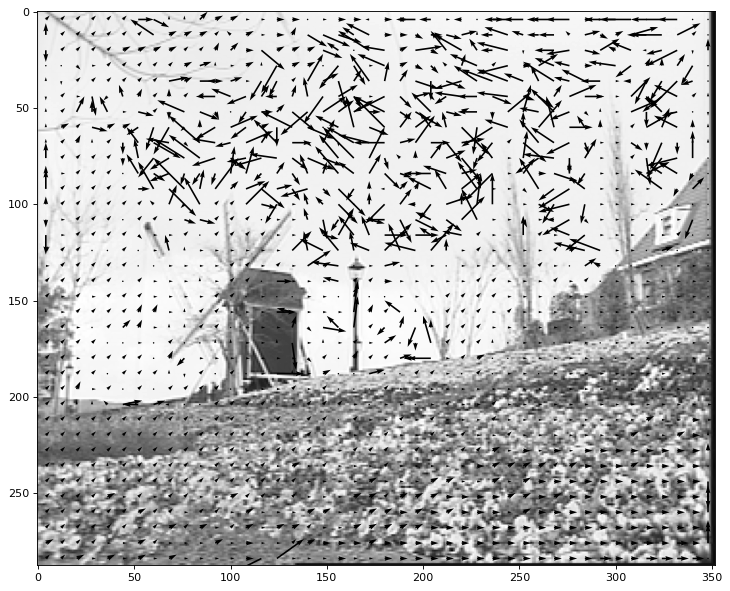

In [16]:
displayMVF(im1, mvf_sad, brow)

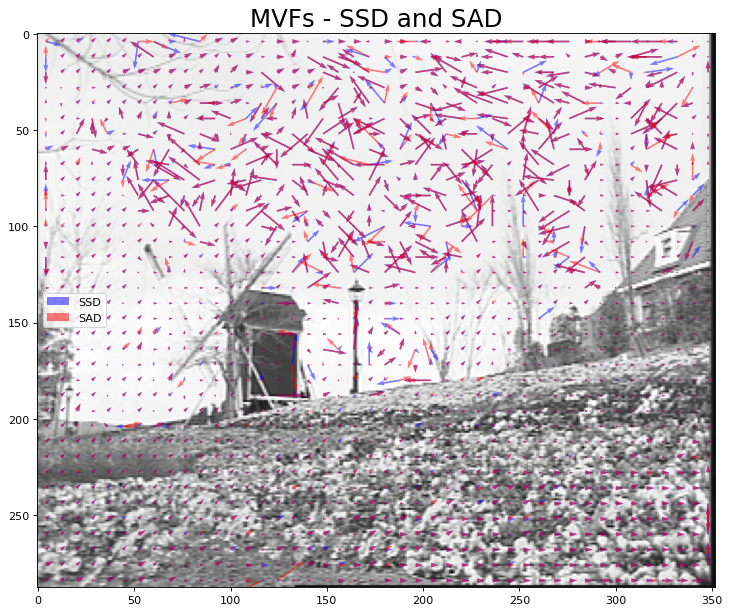

In [17]:
row, col = np.shape(im1)

X, Y = np.meshgrid(np.arange(0, col, brow), np.arange(0, row, brow))
X = X + np.floor(brow / 2.0)
Y = Y + np.floor(brow / 2.0)

# Show image
plt.figure(figsize=(16, 9), dpi=80)

plt.imshow(im1, cmap="gray")

vectRow = mvf_ssd[0:row:brow, 0:col:brow, 0]
vectCol = mvf_ssd[0:row:brow, 0:col:brow, 1]
plt.quiver(X, Y, vectCol, -vectRow, color="b", alpha=0.5, label="SSD")

vectRow = mvf_sad[0:row:brow, 0:col:brow, 0]
vectCol = mvf_sad[0:row:brow, 0:col:brow, 1]
plt.quiver(X, Y, vectCol, -vectRow, color="r", alpha=0.5, label="SAD")

plt.title("MVFs - SSD and SAD", fontsize=22)
plt.legend()
plt.show()

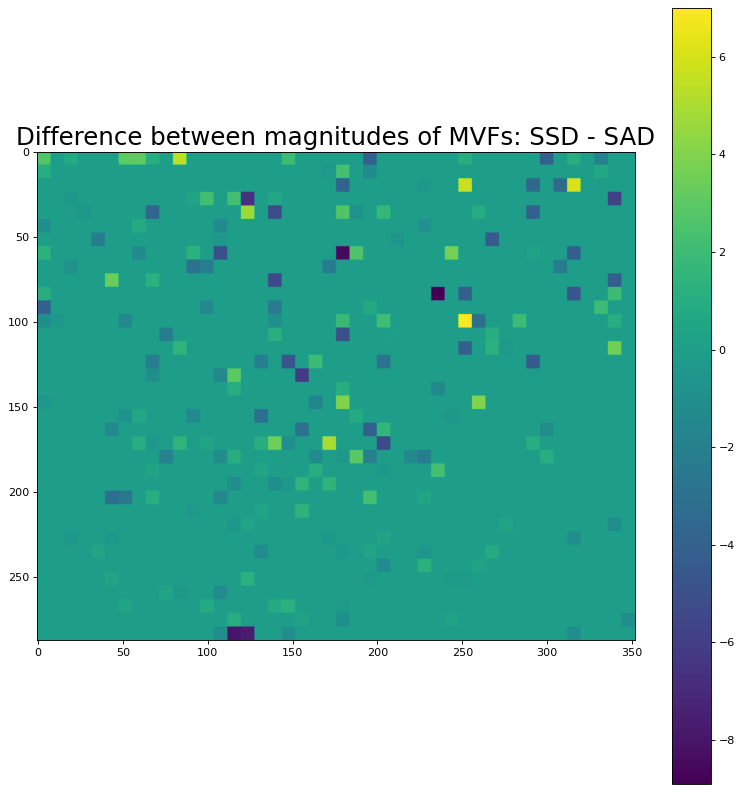

In [18]:
plt.figure(figsize=(10, 10), dpi=80)

plt.imshow(
    np.linalg.norm(mvf_ssd, ord=2, axis=2) - np.linalg.norm(mvf_sad, ord=2, axis=2)
)

plt.title("Difference between magnitudes of MVFs: SSD - SAD", fontsize=22)
plt.colorbar()
plt.tight_layout()
plt.show()

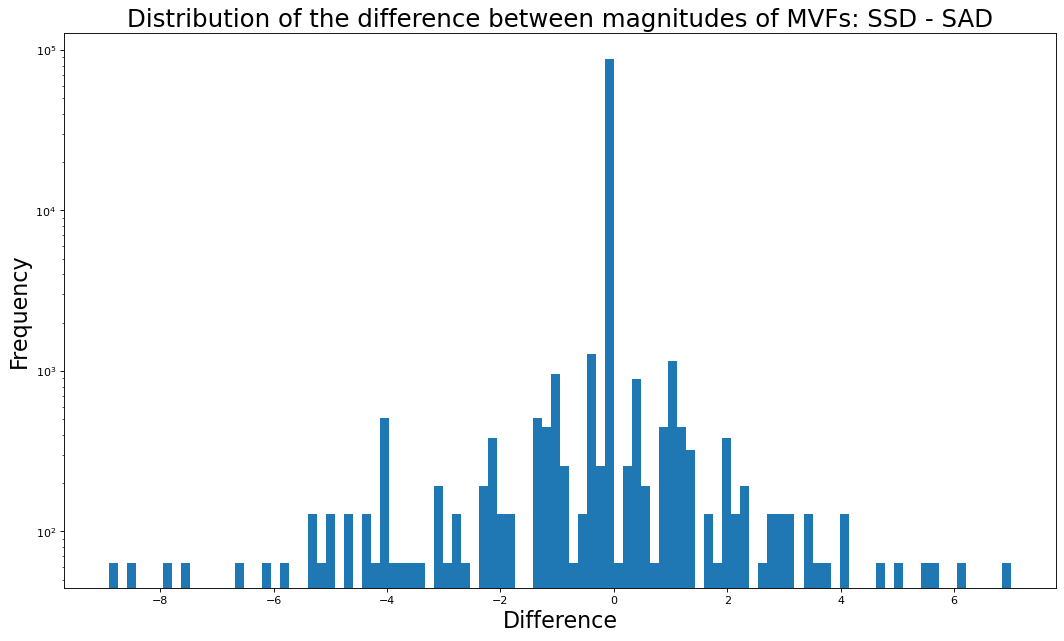

In [19]:
plt.figure(figsize=(16, 9), dpi=80)

plt.hist(
    np.ravel(
        np.linalg.norm(mvf_ssd, ord=2, axis=2) - np.linalg.norm(mvf_sad, ord=2, axis=2)
    ),
    bins=100,
)

plt.title("Distribution of the difference between magnitudes of MVFs: SSD - SAD", fontsize=22)
plt.ylabel("Frequency", fontsize=20)
plt.xlabel("Difference", fontsize=20)
plt.yscale("log")
plt.show()

**Answer**:

When comparing the Sum of Squared Differences (SSD) and Sum of Absolute Differences (SAD) metrics for motion vector estimation, a notable distinction arises in their treatment of outliers. SSD, which computes the sum of squared differences between corresponding pixel values in the blocks being compared, is highly sensitive to outliers due to the squaring operation. Even a few outliers can significantly inflate the overall SSD value, potentially leading to inaccurate motion vector estimation. In contrast, SAD measures the sum of absolute differences between pixel values, which is less susceptible to the influence of outliers. While outliers still contribute to the overall SAD value, they do not have as pronounced an effect as in SSD.

The presence of outliers in motion vector estimation can have significant implications for the accuracy and reliability of the obtained motion vector fields. In SSD, outliers can lead to erratic behavior in the motion vectors, with occasional outliers causing abrupt changes in vector direction or magnitude. This sensitivity to outliers makes SSD prone to inaccuracies, as the algorithm may prioritize minimizing squared differences, potentially resulting in motion vectors being drawn towards outlier regions rather than accurately capturing the underlying motion. On the other hand, the robustness of SAD to outliers allows for smoother and more consistent motion vector fields. While outliers still influence the overall motion vector estimation process, their impact is mitigated, resulting in more stable motion vector fields with fewer disruptions in the motion flow.

Visually comparing motion vector fields obtained using SSD and SAD metrics further highlights their differences. Motion vectors derived from SSD often exhibit more erratic behavior, with outliers causing noticeable deviations in vector direction and magnitude. In contrast, motion vectors computed using SAD are generally smoother and more consistent, with fewer outliers causing disruptions in the overall motion flow. This enhanced resilience to outliers makes SAD particularly valuable in scenarios where noise or artifacts may be present in the video data, as it provides more reliable and robust motion vector estimation.

Motion compensation: compute the motion compensated image and display it. In addition, compute the PSNR.

Comment the difference observed between SSD and SAD in terms of regularity of the motion vector field, PSNR of the prediction and impact of the block size.

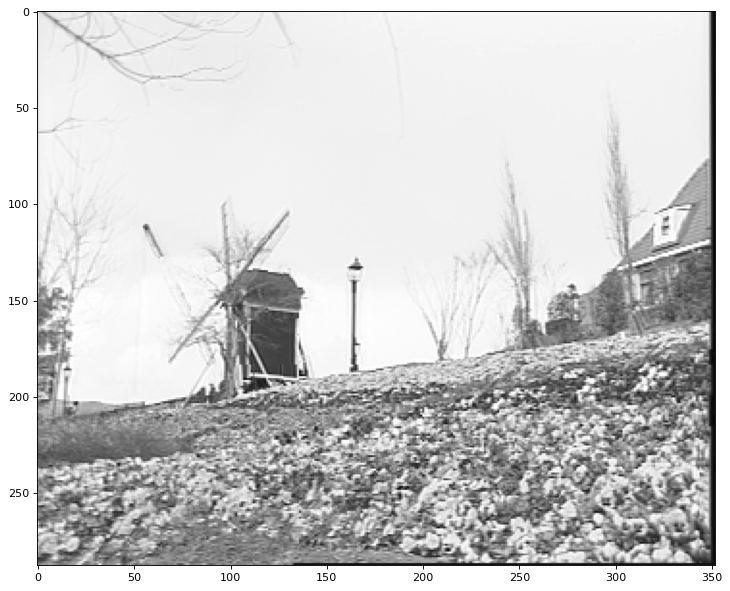

In [20]:
mc_sad = fracMc(im1, mvf_sad)

plt.figure(figsize=(16, 9), dpi=80)
plt.imshow(mc_sad, cmap="gray")
plt.show()

In [21]:
psnr_sad = PSNR(im2, mc_sad)
print(psnr_sad)

23.16830162037859


**Answer**:

The difference observed between Sum of Squared Differences (SSD) and Sum of Absolute Differences (SAD) in terms of the regularity of the motion vector field, Peak Signal-to-Noise Ratio (PSNR) of the prediction, and impact of the block size highlights the advantages and limitations of each metric.

1. Regularity of the Motion Vector Field:
   - SSD: The SSD metric tends to produce a less regular motion vector field compared to SAD. This is because SSD is more sensitive to outliers and small variations in pixel intensity, leading to erratic behavior in the motion vectors.
   - SAD: In contrast, SAD results in a more regular and smoother motion vector field. Its robustness to outliers ensures that motion vectors are more consistent and less influenced by small variations in pixel intensity.

2. PSNR of the Prediction:
   - SSD: Despite the less regular motion vector field, SSD may yield higher PSNR values for the prediction compared to SAD. This is because SSD minimizes squared differences, which can better preserve fine details and edges in the predicted frame.
   - SAD: Conversely, the PSNR of the prediction using SAD may be slightly smaller than SSD. While SAD produces a smoother motion vector field, it may sacrifice some fine details in the prediction due to its absolute difference computation, resulting in marginally lower PSNR values.

3. Impact of the Block Size: Both SSD and SAD metrics are affected by the block size parameter. A smaller block size allows for finer granularity in capturing motion details, potentially leading to more accurate motion vectors. However, smaller block sizes also increase computational complexity. Conversely, larger block sizes reduce computational overhead but may result in less accurate motion estimation, particularly for larger motions or regions with rapid changes.
  
In summary, while SSD may offer higher PSNR values for the prediction due to its ability to preserve fine details, SAD produces a more regular motion vector field and is more robust to outliers. The choice between SSD and SAD depends on the specific requirements of the application, balancing factors such as motion estimation accuracy, computational complexity, and the importance of preserving fine details in the prediction. Additionally, adjusting the block size parameter allows for trade-offs between computational efficiency and motion estimation accuracy, with smaller block sizes providing finer motion details at the cost of increased computation.

## I-2- Regularized algorithms

Now, we will add a regularization term to the metrics (SSD and then SAD) we previously used.

### I-2-1- Regularized SSD-based algorithm

Code the regularized SSD-based algorithm. For the sake of simplicity, the regularizing function is already given.

How does it work and what does it compute?

Try several parameter values, and compare your results with the unregularized algorithms. What can you observe?

In [22]:
lambdas = np.concatenate(([0], np.logspace(-3, 1, 20)))
psnr_ssd_regs = []

for lamb in lambdas:
    mvf_ssd_reg, prediction = me_ssd(im2, im1, brow, bcol, search_radius, lamb=lamb)
    mc_ssd_reg = fracMc(im1, mvf_ssd_reg)
    psnr_ssd_reg = PSNR(im2, mc_ssd_reg)
    psnr_ssd_regs.append(psnr_ssd_reg)
    print(f"PSNR for lambda = {lamb:.5f}: {psnr_ssd_reg}")

PSNR for lambda = 0.00000: 23.226778206199043
PSNR for lambda = 0.00100: 23.224798814219632
PSNR for lambda = 0.00162: 23.223725376604193
PSNR for lambda = 0.00264: 23.221582202004534
PSNR for lambda = 0.00428: 23.218837151932473
PSNR for lambda = 0.00695: 23.214277981464264
PSNR for lambda = 0.01129: 23.207566769062034
PSNR for lambda = 0.01833: 23.1971740713887
PSNR for lambda = 0.02976: 23.17044463171039
PSNR for lambda = 0.04833: 23.13129038747207
PSNR for lambda = 0.07848: 23.05852029034247
PSNR for lambda = 0.12743: 22.859870791676837
PSNR for lambda = 0.20691: 22.300033791072103
PSNR for lambda = 0.33598: 20.73640692327268
PSNR for lambda = 0.54556: 18.549447066603925
PSNR for lambda = 0.88587: 16.94884719316987
PSNR for lambda = 1.43845: 15.826952379310697
PSNR for lambda = 2.33572: 14.960852081980804
PSNR for lambda = 3.79269: 14.395751808979547
PSNR for lambda = 6.15848: 14.20193050813672
PSNR for lambda = 10.00000: 14.053349130293114


In [23]:
print(f"Best PSNR {np.max(psnr_ssd_regs)}\nfor lambda {lambdas[np.argmax(psnr_ssd_regs)]}")

Best PSNR 23.226778206199043
for lambda 0.0


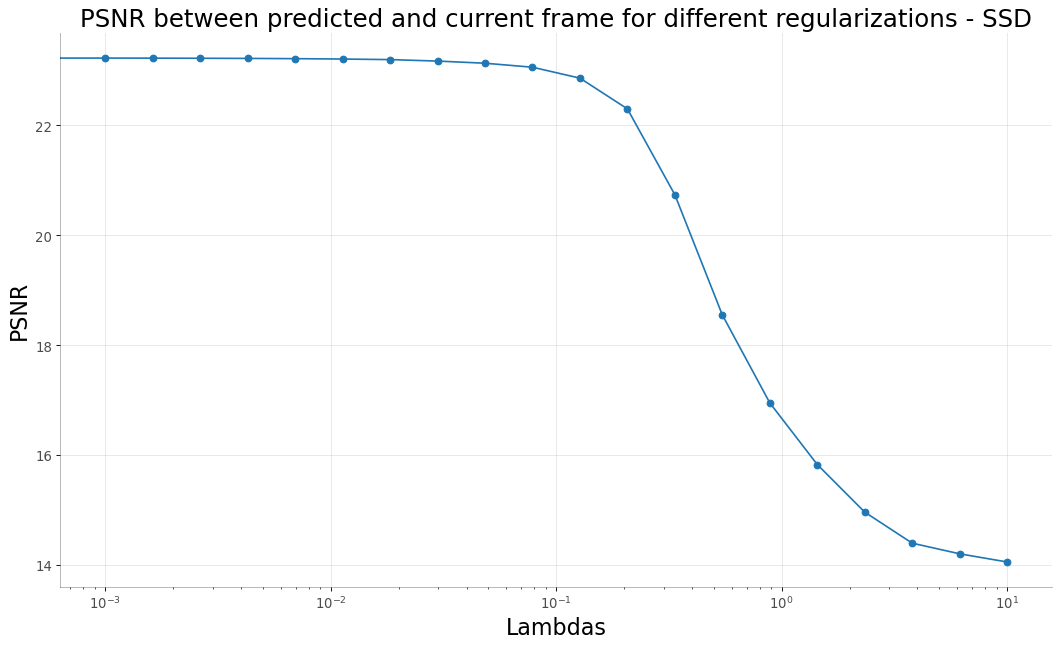

In [24]:
plt.figure(figsize=(16, 9), dpi=80)

plt.plot(lambdas, psnr_ssd_regs, marker="o")
plt.axvline(x=lambdas[np.argmax(psnr_ssd_regs)], linestyle="--", c="r", alpha=0.5)

plt.xticks(fontsize=12, alpha=0.7)
plt.yticks(fontsize=12, alpha=0.7)
plt.title(
    "PSNR between predicted and current frame for different regularizations - SSD",
    fontsize=22,
)
plt.ylabel("PSNR", fontsize=20)
plt.xlabel("Lambdas", fontsize=20)
plt.xscale("log")
plt.grid(alpha=0.3)
plt.gca().spines[["top", "right"]].set_alpha(0.0)
plt.gca().spines[["bottom", "left"]].set_alpha(0.3)

plt.show()

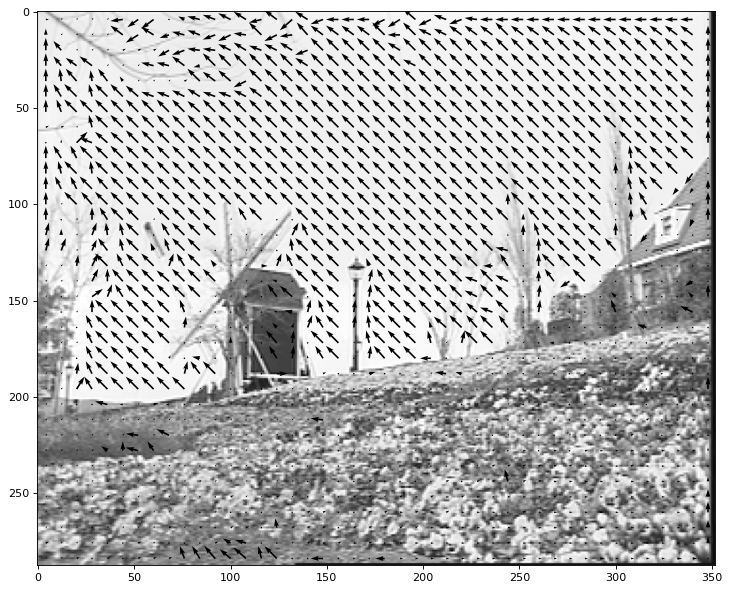

In [25]:
mvf_ssd_reg, prediction = me_ssd(im2, im1, brow, bcol, search_radius, lamb=1e-1)

displayMVF(im1, mvf_ssd_reg, brow)

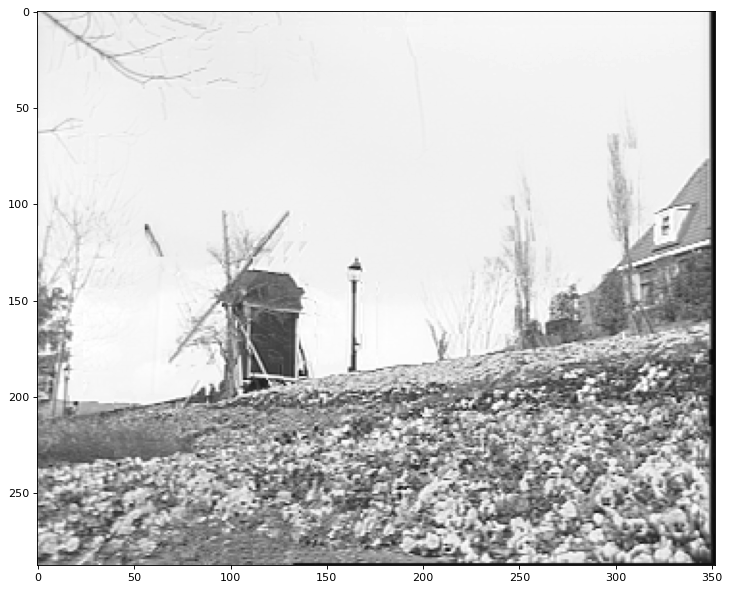

In [26]:
mc_ssd = fracMc(im1, mvf_ssd_reg)

plt.figure(figsize=(16, 9), dpi=80)
plt.imshow(mc_ssd, cmap="gray")
plt.show()

**Answer**:

The `me_ssd` function provided implements a motion estimation algorithm based on the Sum of Squared Differences (SSD) metric, with an option for regularization using a regularization parameter (`lamb`). Here's how it works and what it computes:

1. Motion Estimation Process:
   - For each block in the current frame (`cur`), the algorithm searches for the best corresponding block in the reference frame (`ref`) within a specified search radius.
   - It calculates the SSD between the current block and candidate blocks in the reference frame to determine the best match.
   - The motion vector field (MVF) is then generated based on the displacement between the current block and the best matching block in the reference frame.
   - Additionally, a predicted frame is generated based on the motion estimation results.
2. Regularization:
   - The regularization parameter (`lamb`) allows for regularization of the motion estimation process. When `lamb` is non-zero, the algorithm minimizes a regularized cost function, which includes both the SSD and a regularization term.
   - The regularization term penalizes deviations from a predictor vector (`pV`), which is typically computed based on neighboring motion vectors. This regularization helps ensure that the estimated displacement is not too far from the surrounding motion vectors.

To compare the results with the unregularized algorithm and observe the impact of different parameter values, one can try various settings for `lamb`, block size (`brow`, `bcol`), and search radius (`search`). Here are some observations one might make:

- Effect of Regularization: Increasing the regularization parameter (`lamb`) may lead to smoother motion vector fields and potentially improved prediction accuracy, particularly in regions with high motion or textureless areas. However, excessive regularization can also result in overly smoothed motion vectors, leading to loss of detail in the predicted frames.
- Impact of Block Size and Search Radius: Adjusting the block size and search radius parameters can affect both computational efficiency and motion estimation accuracy. Smaller block sizes allow for finer motion details to be captured but increase computational complexity. Similarly, larger search radii increase the likelihood of finding the best match but also increase computation time.
- Comparison with Unregularized Algorithm: One may observe differences in prediction quality, motion vector smoothness, and computational efficiency between the regularized and unregularized versions of the algorithm. Regularization can help mitigate issues such as noise and outliers in the motion estimation process, leading to improved prediction accuracy under certain conditions. However, it also introduces additional computational overhead due to the regularization term calculation.

In summary, experimenting with different parameter values and comparing the results between the regularized and unregularized algorithms can provide insights into the trade-offs between prediction accuracy, computational complexity, and robustness to noise and outliers in motion estimation.

For this case, increasing the regularization term leads to a decrease on the PSNR and the unregularized algorithm yielded better results.

### I-2-2- Regularized SAD-based algorithm

Code the regularized SAD-based algorithm.

Try several parameter values, and compare your results with the unregularized algorithms and the regularized SSD-based algorithm.

In [27]:
lambdas = np.concatenate(([0], np.logspace(-3, 1, 20)))
psnr_sad_regs = []

for lamb in lambdas:
    mvf_sad_reg, prediction = me_sad(im2, im1, brow, bcol, search_radius, lamb=lamb)
    mc_sad_reg = fracMc(im1, mvf_sad_reg)
    psnr_sad_reg = PSNR(im2, mc_sad_reg)
    psnr_sad_regs.append(psnr_sad_reg)
    print(f"PSNR for lambda = {lamb:.5f} : {psnr_sad_reg}")

PSNR for lambda = 0.00000 : 23.16830162037859
PSNR for lambda = 0.00100 : 23.16830244025851
PSNR for lambda = 0.00162 : 23.168301073792062
PSNR for lambda = 0.00264 : 23.16828768244355
PSNR for lambda = 0.00428 : 23.16836352174822
PSNR for lambda = 0.00695 : 23.169846822159997
PSNR for lambda = 0.01129 : 23.16979077746166
PSNR for lambda = 0.01833 : 23.169825224361325
PSNR for lambda = 0.02976 : 23.1700584315904
PSNR for lambda = 0.04833 : 23.169744165226877
PSNR for lambda = 0.07848 : 23.168175770645465
PSNR for lambda = 0.12743 : 23.163875295801873
PSNR for lambda = 0.20691 : 23.16037106230943
PSNR for lambda = 0.33598 : 23.131692938200754
PSNR for lambda = 0.54556 : 23.071487882644487
PSNR for lambda = 0.88587 : 22.90610900111852
PSNR for lambda = 1.43845 : 22.366153378017916
PSNR for lambda = 2.33572 : 20.12686078324333
PSNR for lambda = 3.79269 : 17.296927349231186
PSNR for lambda = 6.15848 : 15.625287394600377
PSNR for lambda = 10.00000 : 14.661516420190353


In [28]:
print(f"Best PSNR {np.max(psnr_sad_regs)}\nfor lambda {lambdas[np.argmax(psnr_sad_regs)]}")

Best PSNR 23.1700584315904
for lambda 0.029763514416313176


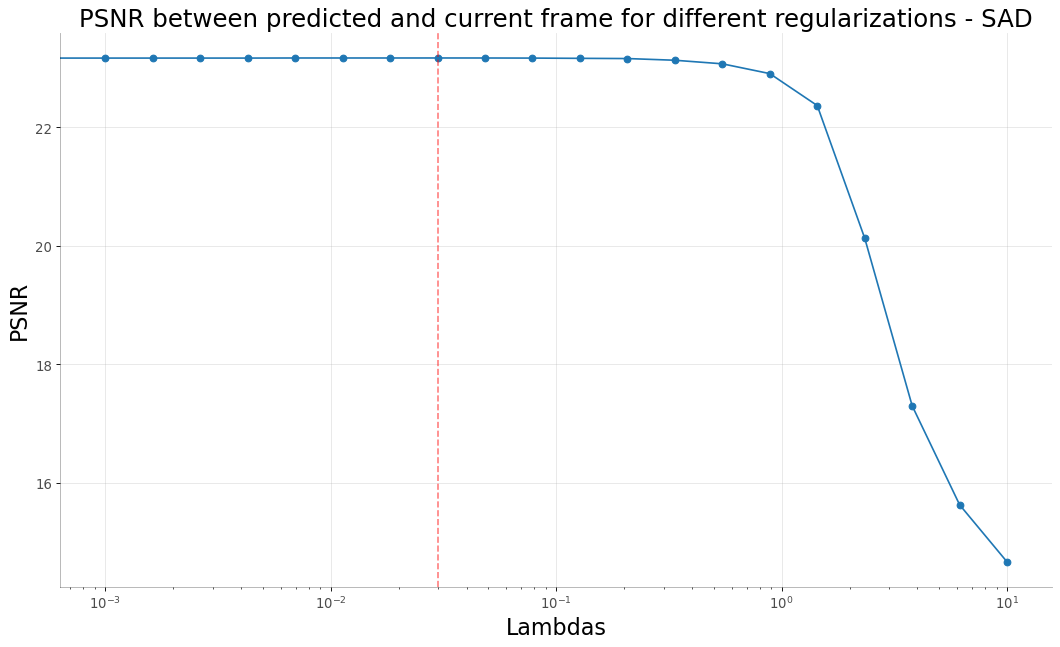

In [29]:
plt.figure(figsize=(16, 9), dpi=80)

plt.plot(lambdas, psnr_sad_regs, marker="o")
plt.axvline(x=lambdas[np.argmax(psnr_sad_regs)], linestyle="--", c="r", alpha=0.5)

plt.xticks(fontsize=12, alpha=0.7)
plt.yticks(fontsize=12, alpha=0.7)
plt.title(
    "PSNR between predicted and current frame for different regularizations - SAD",
    fontsize=22,
)
plt.ylabel("PSNR", fontsize=20)
plt.xlabel("Lambdas", fontsize=20)
plt.xscale("log")
plt.grid(alpha=0.3)
plt.gca().spines[["top", "right"]].set_alpha(0.0)
plt.gca().spines[["bottom", "left"]].set_alpha(0.3)

plt.show()

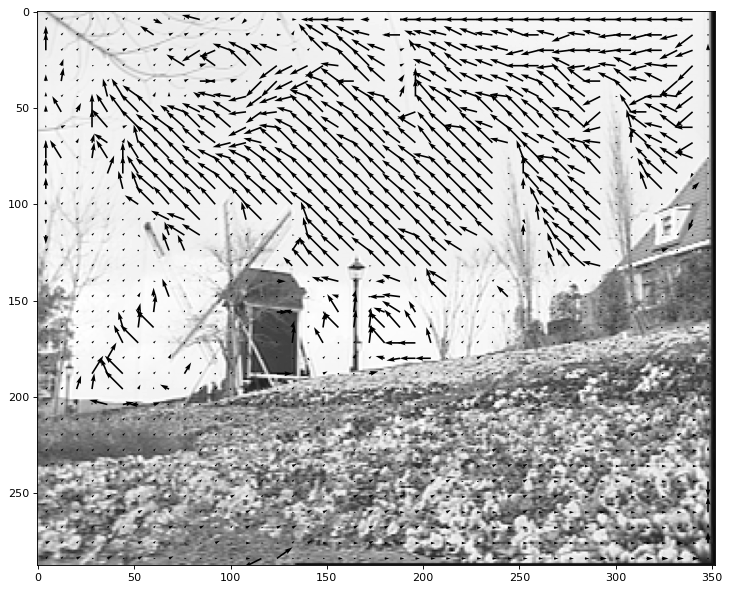

In [30]:
mvf_sad_reg, prediction = me_sad(im2, im1, brow, bcol, search_radius, lamb=1e-1)

displayMVF(im1, mvf_sad_reg, brow)

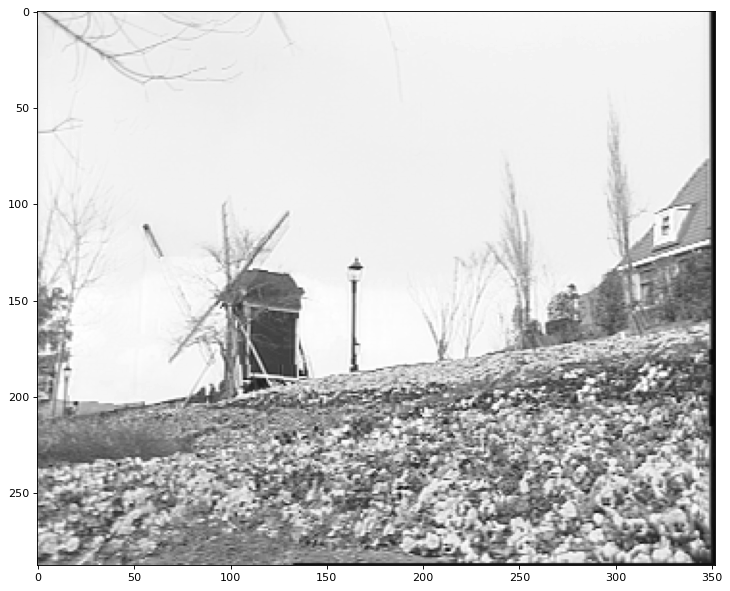

In [31]:
mc_sad = fracMc(im1, mvf_sad_reg)

plt.figure(figsize=(16, 9), dpi=80)
plt.imshow(mc_sad, cmap="gray")
plt.show()

**Answer**:

For this case, over-increasing the regularization term leads to a decrease on the PSNR and the unregularized algorithm yielded marginally better results.

# Optical flow

You will now implement the Horn and Schunck algorithm to estimate the optic flow. The two images we will consider here have a more local movement vector field, since we are considering small movements in a face.

In [32]:
im1 = loadmat("akiyo_cif1.mat")["im1"]
im1 = im1.astype("float")
im2 = loadmat("akiyo_cif2.mat")["im2"]
im2 = im2.astype("float")

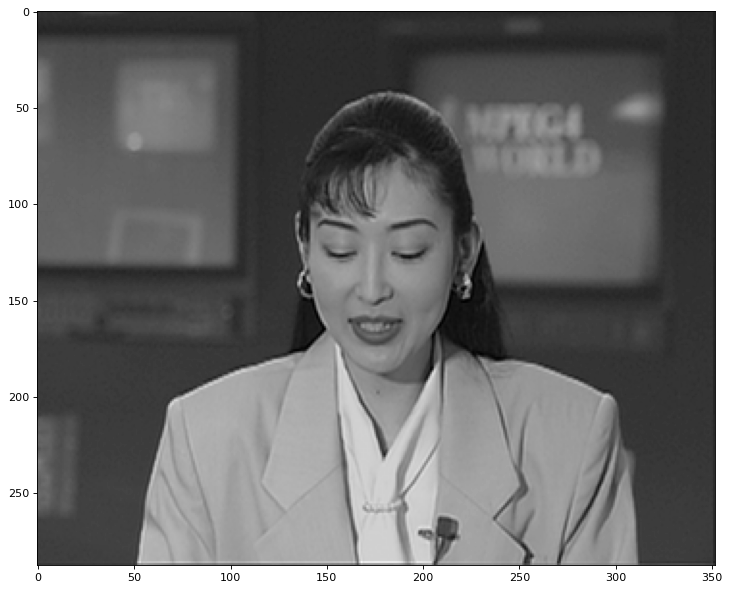

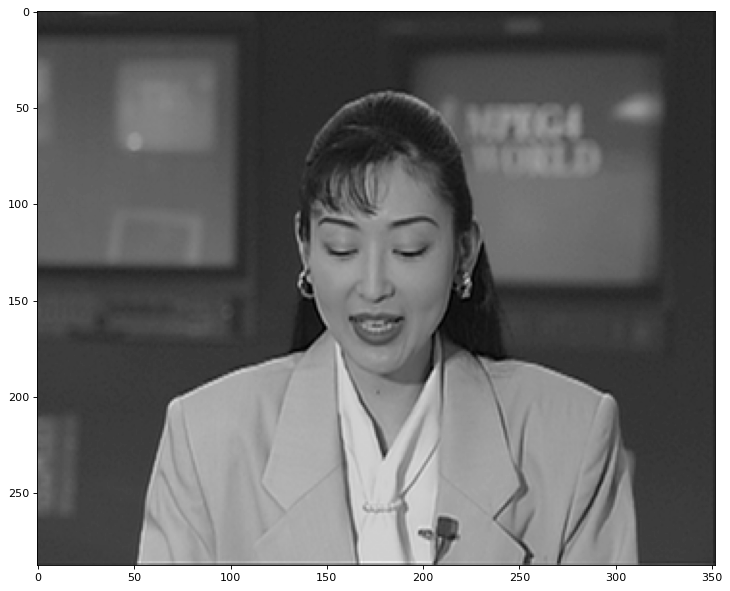

In [33]:
plt.figure(figsize=(16, 9), dpi=80), plt.imshow(im1, cmap="gray")
plt.figure(figsize=(16, 9), dpi=80), plt.imshow(im2, cmap="gray")
plt.show()

Compute the optical flow by filling the gaps in the Horn and Schunck function. You can use the motion field that you estimated before with the block matching algorithm to initialize the Horn and Schunck method.

As a reminder, the optical flow is implemented by the iterative Horn and Schunck's algorithm:
$$
u^{n+1} = \bar{u}^n - f_x \frac{\bar{u}^n f_x + \bar{v}^n f_y + f_t}{\alpha^2 + \|\nabla f\|^2}
$$
$$
v^{n+1} = \bar{v}^n - f_y \frac{\bar{u}^n f_x + \bar{v}^n f_y + f_t}{\alpha^2 + \|\nabla f\|^2}
$$
where $u^n$ is the value of the $u$ component at the $n$-th iteration, and $\bar{u}$ is the local average of $u$.

In [34]:
brow = 16
bcol = 16
search_radius = 13

mvf_ssd, prediction = me_ssd(im2, im1, brow, bcol, search_radius)

In [35]:
def computeDerivatives(im1, im2):
    kernel1D = np.expand_dims(
        (1.0 / 12.0) * np.array([-1.0, 8.0, 0.0, -8.0, 1.0]), axis=1
    ).T
    fx = convolve2d(im1, kernel1D, "same")
    fy = convolve2d(im1, kernel1D.T, "same")
    ft = convolve2d(im1, 0.25 * np.ones((2, 2)), "same") + convolve2d(
        im2, -0.25 * np.ones((2, 2)), "same"
    )
    fx = -fx
    fy = -fy

    return fx, fy, ft


def HS(im1, im2, uInitial, vInitial, alpha=1, ite=100, blur=1.0):
    """
    Horn-Schunck optical flow method.
    Horn, B.K.P., and Schunck, B.G., Determining Optical Flow, AI(17), No. 1-3, August 1981, pp. 185-203 http://dspace.mit.edu/handle/1721.1/6337

    [u, v] = HS(im1, im2, alpha, ite, uInitial, vInitial, displayFlow)

    Parameters
    ----------
    im1, im2 : np.array
        Two subsequent frames or images.
    uInitial, vInitial: np.array
        Initial values for the (u,v) flow. If well initialized, the flow would converge faster and hence would need less iterations.
    alpha : scalar
        A parameter that reflects the influence of the smoothness term.
    ite : int
        Number of iterations.

    Returns
    -------
    u,v : np.array
        Optical flow.
    """

    im1 = gaussian_filter(im1, blur)
    im2 = gaussian_filter(im2, blur)

    # Set initial value for the flow vectors
    u = uInitial.copy()
    v = vInitial.copy()

    # Estimate spatiotemporal derivatives
    fx, fy, ft = computeDerivatives(im1, im2)

    # Averaging kernel
    kernel_1 = np.array(
        [
            [1.0 / 12.0, 1.0 / 6.0, 1.0 / 12.0],
            [1.0 / 6.0, 0.0, 1.0 / 6.0],
            [1.0 / 12.0, 1.0 / 6.0, 1.0 / 12.0],
        ]
    )

    for i in range(ite):
        # Compute local averages of the flow vectors using kernel_1
        uAvg = convolve2d(u, kernel_1)[1:-1, 1:-1]
        vAvg = convolve2d(v, kernel_1)[1:-1, 1:-1]

        # Compute flow vectors constrained by its local average and the optical flow constraints
        u = uAvg - fx * (uAvg * fx + vAvg * fy + ft) / (
            alpha**2 + np.linalg.norm(fx + fy + ft) ** 2
        )
        v = vAvg - fx * (uAvg * fx + vAvg * fy + ft) / (
            alpha**2 + np.linalg.norm(fx + fy + ft) ** 2
        )

    u[np.isnan(u)] = 0
    v[np.isnan(v)] = 0

    return u, v

In [36]:
alpha = 100
ite = 100

# Rem: pay attention to the inversion of the order compare to me_ssd.
uInitial = mvf_ssd[:, :, 0]
vInitial = mvf_ssd[:, :, 1]
[u, v] = HS(im2, im1, uInitial, vInitial, alpha, ite, blur=1.0)

Display the motion field and compute the PSNR. Do you observe any improvement compare to block-matching algorithms? Explain. You can test on both the Akiyo and Flowers images.

In [37]:
mvf_hs = np.zeros((np.shape(v)[0], np.shape(v)[1], 2))
mvf_hs[:, :, 0] = v
mvf_hs[:, :, 1] = u

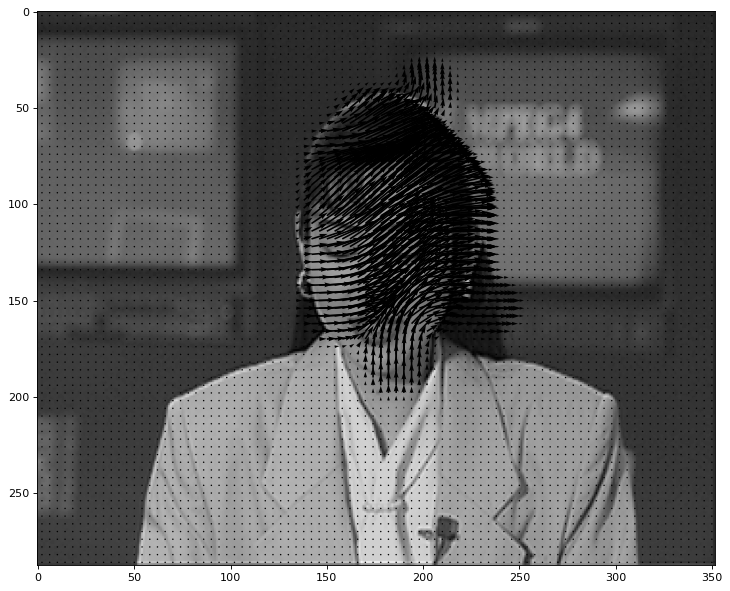

In [38]:
displayMVF(im1, mvf_hs, 4)

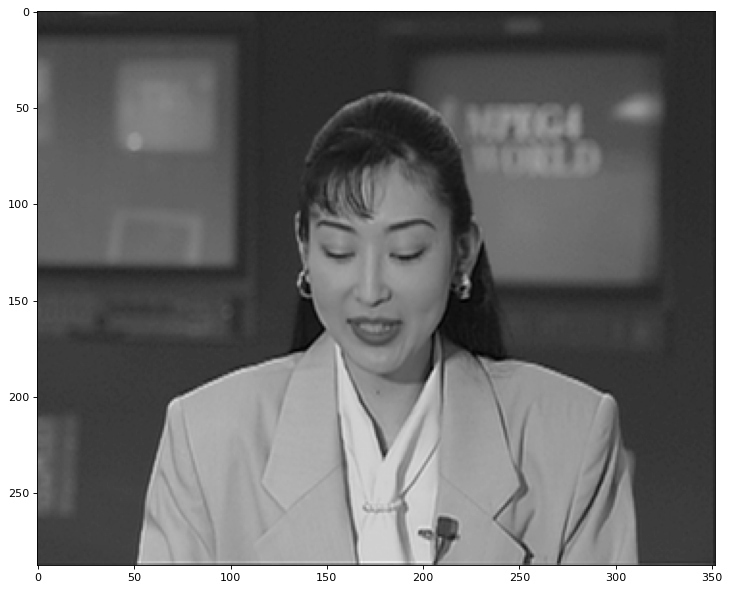

In [39]:
mc_hs = fracMc(im1, mvf_hs)

plt.figure(figsize=(16, 9), dpi=80)
plt.imshow(mc_hs, cmap="gray")
plt.show()

In [40]:
mc_ssd = fracMc(im1, mvf_ssd)
print(PSNR(im2, mc_ssd))

40.463264244372816


In [41]:
psnr_hs = PSNR(im2, mc_hs)
print(psnr_hs)

32.582984059764286


In [42]:
print(PSNR(im2, im1))

34.867588879410675


**Answer**:

The Horn and Schunck optical flow algorithm aims to estimate the motion field between two consecutive frames by enforcing two key assumptions: the Constant Color/Illumination Hypothesis (CIH) and the Small Motion Assumption. These assumptions imply that the appearance of the objects in the scene does not change significantly over time and that points in the scene do not move too far between frames. However, it's important to note that real-world scenarios may not always satisfy these assumptions.

Compared to block-matching algorithms, such as the Sum of Squared Differences (SSD) or Sum of Absolute Differences (SAD) methods, the Horn and Schunck algorithm offers several advantages and drawbacks:

1. Advantages:
   - a. Global Approach: The Horn and Schunck algorithm computes the optical flow for all points in the image simultaneously, resulting in a global motion estimation approach. This can provide more accurate motion estimation, especially in regions with complex motion patterns.
   - b. Smoothness Constraints: The algorithm imposes smoothness constraints on the motion field, promoting spatial coherence in the estimated motion vectors. This regularization helps reduce noise and outliers in the optical flow estimation.
   - c. Robustness to Noise: The Horn and Schunck algorithm tends to be more robust to noise compared to block-matching algorithms, as it considers the entire image rather than individual blocks.
2. Drawbacks:
   - a. Assumption Limitations: The CIH and Small Motion Assumption may not hold true in all real-world scenarios. Variations in lighting conditions, occlusions, and large motions can violate these assumptions, leading to inaccuracies in the optical flow estimation.
   - b. Computational Complexity: The algorithm involves solving a partial differential equation (PDE) over the entire image, which can be computationally intensive, especially for high-resolution images.
   - c. Parameter Sensitivity: The performance of the Horn and Schunck algorithm can be sensitive to its parameters, such as the regularization parameter and the number of iterations used in solving the PDE. Fine-tuning these parameters may be necessary to achieve optimal results.
3. Comparison with Block-Matching Algorithms: Overall, the Horn and Schunck algorithm may offer improvements over block-matching algorithms in scenarios where the assumptions of constant color/illumination and small motion hold true. It can provide more accurate and spatially coherent motion estimation, particularly in regions with complex motion patterns or under challenging lighting conditions. However, in cases where these assumptions are violated, such as scenes with significant changes in lighting or large motions, block-matching algorithms may perform better due to their local and more adaptive nature.

In conclusion, while the Horn and Schunck algorithm offers a global and regularization-based approach to optical flow estimation, its effectiveness depends on the extent to which the underlying assumptions are met in the given scenario. Careful consideration of these assumptions and their applicability to the specific application domain is essential when choosing between the Horn and Schunck algorithm and block-matching algorithms for optical flow estimation.